# Train a new model

In this notebook we will learn how to train a new model for axon & myelin segmentation. It covers the following scenario:

* Train a model from scratch by defining the parameters of the network
* Make inference using the trained model


### Imports

In [1]:
import json
import os
import time
import tensorflow as tf
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import imageio
import matplotlib.pyplot as plt
from shutil import copy

from AxonDeepSeg.train_network import train_model
from AxonDeepSeg.apply_model import axon_segmentation

# reset the tensorflow graph for new training
tf.reset_default_graph()

%matplotlib inline

### 1. Train a new model

#### 1.1. Create subfolder to save new model and its parameters.

For simplicity, the new model will be created under the `models/` folder in the AxonDeepSeg repository. The name of the model folder will be generated automatically using the date and time (to avoid multiple instances). If you want to use a specific name for the model folder, uncomment the 2nd line of the next cell.

In [1]:
dir_name = time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S")
# dir_name = 'the_name_of_my_model_folder'

path_model = os.path.join('../models/', dir_name)

if not os.path.exists(path_model):
    os.makedirs(path_model)
    
filename = '/config_network.json'

NameError: name 'time' is not defined

#### 1.2. Define the name and path of the training set

Here we assume that the training data folder has already been created by following the guidelines detailed in [guide_dataset_building.ipynb](https://github.com/neuropoly/axondeepseg/blob/master/notebooks/guide_dataset_building.ipynb).

The expected structure of the training data folder (specified here by `path_training`) is the following:

~~~
data_training
 └── Train
      └── image_0.png
         * *mask_0.png*
         * *image_1.png*
         * *mask_1.png*
         
         ...
         * *image_n.png*
         * *mask_n.png*
         
    * **Validation**
         * *image_0.png*
         * *mask_0.png*
         * *image_1.png*
         * *mask_1.png*
         
         ...
         * *image_m.png*
         * *mask_m.png*   

~~~

In [3]:
trainingset_name = 'SEM_3c_256'
path_training = '/Users/Dropbox/SEM_3c_256/training'

#### 1.3. Define the configuration parameters of the training.

The network and training parameters (i.e. hyperparameters) are defined in the next cell. A shallow network is defined here for testing purposes (depth of 2, 2 convolutions per layer, 3x3 kernels, 5 and 10 feature channels, standard max pooling for feature downsampling). **Note that this "toy" architecture is used for testing purposes here and is not necessarily expected to generate good results on a test microscopy sample.**

Here is a quick guide on the main parameters. For more information, please refer to the paper.

##### General parameters:
* **"n_classes":** Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
* **"thresholds":** Thresholds for the 3-class classification problem. Do not modify.
* **"trainingset_patchsize":** Patch size of the training set in pixels (note that the patches have the same size in both dimensions).
* **"trainingset":** Name of the training set.
* **"batch_size":** Batch size, i.e. the number of training patches used in one iteration of the training. Note that a larger batch size will take more memory.

##### Network architecture parameters:
* **"depth":** Depth of the network (i.e. number of blocks of the U-net).
* **"convolution_per_layer":** Number of convolution layers used at each block.
* **"size_of_convolutions_per_layer":** Kernel size of each convolution layer of the network.
* **"features_per_convolution":** Number of features of each convolution layer.
* **"downsampling":** Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
* **"dropout":** Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).

##### Learning rate parameters:
* **"learning_rate":** Learning rate to use in the training.
* **"learning_rate_decay_activate":** Set to "True" to use a decay on the learning rate.
* **"learning_rate_decay_period":** Period of the learning rate decay, expressed in number of images (samples) seen.
* **"learning_rate_decay_type":** Type of decay to use. An exponential decay will be used by default unless this param. is set to "polynomial" (to use a polynomial decay).
* **"learning_rate_decay_rate":** Rate of the decay to use for the exponential decay. This only applies when the user does not set the decay type to "polynomial".

##### Batch normalization parameters:
* **"batch_norm_activate":** Set to "True" to use batch normalization during the training.     
* **"batch_norm_decay_decay_activate":** Set to "True" to activate an exponential decay for the batch normalization step of the training.    
* **"batch_norm_decay_starting_decay":** The starting decay value for the batch normalization. 
* **"batch_norm_decay_ending_decay":** The ending decay value for the batch normalization. 
* **"batch_norm_decay_decay_period":** Period of the batch normalization decay, expressed in number of images (samples) seen.

##### Weighted cost parameters:
* **"weighted_cost-activate":** Set to "True" to use weights based on the class in the cost function for the training. 
* **"weighted_cost-balanced_activate":** Set to "True" to use weights in the cost function to correct class imbalance. 
* **"weighted_cost-balanced_weights":** Values of the weights for the class imbalance. Typically, larger weights are assigned to classes with less pixels to add more penalty in the cost function when there is a misclassification. Order of the classes in the weights list: background, myelin, axon.
* **"weighted_cost-boundaries_activate":** Set to "True" to add weights to the boundaries (e.g. penalize more when misclassification happens in the axon-myelin interface).
* **"weighted_cost-boundaries_sigma":** Value to control the distribution of the boundary weights (if activated).  

##### Data augmentation parameters (+):
* **"da-type":** Type of data augmentation procedure. Option **"all"** applies all selected data augmentation transformations sequentially, while option **"random"** only applies one of the selected transformations (randomly) to the sample(s).
* List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. For each type of data augmentation, the order needs to be specified if you decide to apply more than one transformation sequentially. For instance, setting the "da-0-shifting-activate" parameter to 'True' means that the shifting is the first transformation that will be applied to the sample(s) during training. 

(+) You can find more information about the range of transformations applied to the patches for each the data augmentation techniques used in the `data_augmentation.py` file of the repository. You will also be able to change the data augmentation parameters of each technique. The default ranges of transformations for the data augmentation techniques used are:
* **Shifing:** Random horizontal and vertical shifting between 0 and 10% of the patch size, sampled from a uniform distribution.
* **Rotation:** Random rotation, angle between 5 and 89 degrees, sampled from a uniform distribution.
* **Rescaling:** Random rescaling of a randomly sampled factor between 1/1.2 and 1.2.
* **Flipping:** Random fipping: vertical fipping or horizontal fipping.
* **Blurring:** Gaussian blur with the standard deviation of the gaussian kernel being uniformly sampled between 0 and 4.
* **Elastic deformation:**: Random elastic deformation with uniformly sampled deformation coefficient α=[1–8] and fixed standard deviation σ=4.

In [4]:
config = {
    
# General parameters:    
  "n_classes": 3,
  "thresholds": [0, 0.2, 0.8],    
  "trainingset_patchsize": 256,    
  "trainingset": "SEM_3c_256",    
  "batch_size": 8,

# Network architecture parameters:     
  "depth": 2,
  "convolution_per_layer": [2, 2],
  "size_of_convolutions_per_layer": [[3, 3], [3, 3]],
  "features_per_convolution": [[[1, 5], [5, 5]], [[5, 10], [10, 10]]],
  "downsampling": "maxpooling",
  "dropout": 0.75, 
     
# Learning rate parameters:    
  "learning_rate": 0.001,    
  "learning_rate_decay_activate": True,    
  "learning_rate_decay_period": 24000, 
  "learning_rate_decay_type": "polynomial", 
  "learning_rate_decay_rate": 0.99,
    
# Batch normalization parameters:     
  "batch_norm_activate": True,     
  "batch_norm_decay_decay_activate": True,    
  "batch_norm_decay_starting_decay": 0.7, 
  "batch_norm_decay_ending_decay": 0.9, 
  "batch_norm_decay_decay_period": 16000,
        
# Weighted cost parameters:    
  "weighted_cost-activate": True, 
  "weighted_cost-balanced_activate": True, 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3], 
  "weighted_cost-boundaries_sigma": 2, 
  "weighted_cost-boundaries_activate": False, 
    
# Data augmentation parameters:    
  "da-type": "all", 
  "da-2-random_rotation-activate": False, 
  "da-5-noise_addition-activate": False, 
  "da-3-elastic-activate": True, 
  "da-0-shifting-activate": True, 
  "da-4-flipping-activate": True, 
  "da-1-rescaling-activate": False    
}

#### 1.4. Save config. parameters of the network as configuration file (.json).

After the config. parameters of the network to be trained are defined, they are saved into a .json file in the model folder. This .json file keeps tract of the network and model parameters in a structured way.

In [5]:
if os.path.exists(path_model+filename):
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())
else: # There is no config file for the moment
    with open(path_model+filename, 'w') as f:
        json.dump(config, f, indent=2)
    with open(path_model+filename, 'r') as fd:
        config_network = json.loads(fd.read())

#### 1.5. Launch the training procedure.

The training can be launched by calling the *'train_model'* function. After each epoch, the function will display the loss and accuracy of the model. The model is automatically saved at every 5 epochs.

In [ ]:
train_model(path_training, path_model, config)

#### 1.6. Monitor the training with Tensorboard.

In order to monitor the training procedure (loss and accuracy graphs, gradients, activations, ...), it is strongly suggested to use TensorBoard, a user interface that allows visualization of the main training and validation graphs. In order to to that, launch the following command on the terminal (make sure the virtual env. created for AxonDeepSeg is activated):
```
tensorboard --logdir path_of_the_model_folder --port 6006
```
Here, the `path_of_the_model_folder` parameter is the path to the folder than contains the model that is being trained, while the `port` parameter (not mandatory) is the port number where the TensorBoard interface is going to launch on a web server (typically port 6006). To access the TensorBoard interface, you can then go to the following address on a web server (example here with port 6006 used):
```
http://localhost:6006/
```

Using TensorBoard can also help identify bugs or errors during the training procedure.

### STEP 2: TEST THE TRAINED MODEL.

#### 2.1. Set the path of the test image to be segmented with the trained model.

In [7]:
# reset the tensorflow graph for new testing
tf.reset_default_graph()

path_img = '/Users/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/image.png'

#### 2.2. Set the folder name of the trained model.

In [8]:
model_name = dir_name

img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

path_model = os.path.join('..','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())

#### 2.3. Launch the image segmentation.

In [9]:
prediction = axon_segmentation(path_folder, file_name, path_model, config_network, verbosity_level=3)

Loading acquisitions ...
Rescaling acquisitions to the target resolution ...
Graph construction ...
Beginning inference ...
processing patch 1 of 20
processing patch 2 of 20
processing patch 3 of 20
processing patch 4 of 20
processing patch 5 of 20
processing patch 6 of 20
processing patch 7 of 20
processing patch 8 of 20
processing patch 9 of 20
processing patch 10 of 20
processing patch 11 of 20
processing patch 12 of 20
processing patch 13 of 20
processing patch 14 of 20
processing patch 15 of 20
processing patch 16 of 20
processing patch 17 of 20
processing patch 18 of 20
processing patch 19 of 20
processing patch 20 of 20


#### 2.4. Load the segmented image and display it.

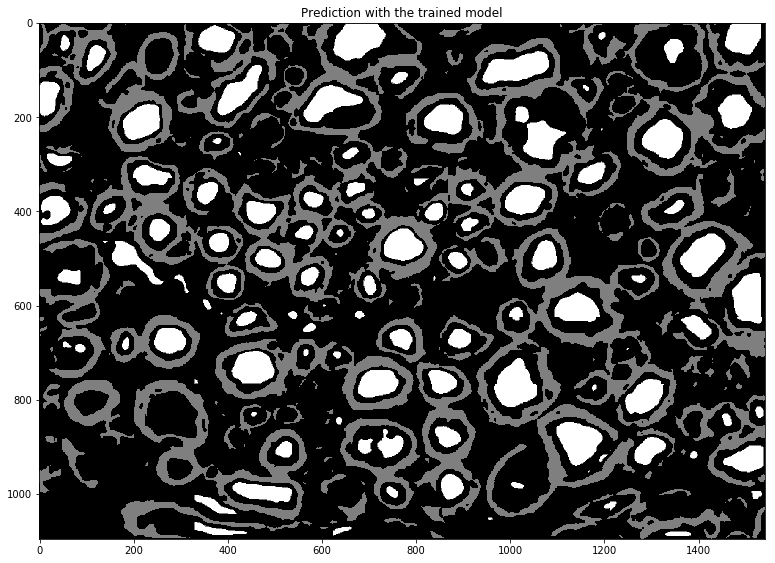

In [10]:
pred_img_path = '/Users/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/AxonDeepSeg.png'
pred_img = imageio.imread(pred_img_path)

plt.figure(figsize=(13,10))
plt.title('Prediction with the trained model')
plt.imshow(pred_img,cmap='gray')